# Geo Rasterize Slope using UDTF

The following example is a walk through to show how to use a complex User Defined Table Function (UDTF) on a large scale application.

`tf_geo_rasterize_slope` is a UDTF that calcultate the slope profile of a terrain. This is useful for infrastructure planning. The slope value has a direct impact on construction costs, hence we want to classify areas in three groups: low, medium and high slopes.

```sql
tf_geo_rasterize_slope(
    raster => CURSOR(x, y, z),
    bin_dim_meters => 10.0,
    geographic_coords => true,
    neighborhood_fill_radius => 20,
    fill_only_nulls => false,
    compute_slope_in_degrees => true,
)
```

`raster` corresponds to the topography of the terrain. `bin_dim_meters` is the gridding–after internally projecting into a planar meters coordinate system if needed. `neighborhood_fill_radius` is in 'bins' and applies a flood fill of average slope.  If `fill_only_nulls` is false, then the fill only applies to nulls, otherwize it generally smoothes. `compute_slope_in_degrees` gives degrees, otherwise 'radians' are returned. The output of the function is a table containing slope and angle data.


<div class="alert alert-block alert-info">
<b>Note:</b> When <code>geographic_coords => true</code>, the Coordinate Reference System (CRS) of the points' coordinates needs to be WGS84 (latitude, longitude). Otherwize, coordinates are assumed to be in meters (valid for a given UTM region). The elevation data is either referenced to the ground or the mean sea level (AMSL).
</div>

<div class="alert alert-block alert-info">
<b>Note:</b> Using named parameters in HeavyDB is supported with HeavyDB>=6. You can use previous versions by removing the annotation. E.g. <code>geographic_coords => true</code> would just be <code>true</code>.
</div>

## Setup

On top of *HeavyDB*, the following packages are used.

* [heavyai](https://heavyai.readthedocs.io/en/latest/): interact with HeavyDB
* [RBC](https://rbc.readthedocs.io/): create UDF in Python and register to HeavyDB
* [pandas](https://pandas.pydata.org): tabular data structure
* [s3fs](https://s3fs.readthedocs.io/): load s3 data
* [geopandas](https://geopandas.org/en/stable): geo-spatial plotting, helper functions on top of pandas
* [contextily](https://github.com/geopandas/contextily): background maps
* [matplotlib](https://matplotlib.org): plotting library
* [ipympl](https://github.com/matplotlib/ipympl): interactive matplotlib

They are all available on PyPi or conda-forge (recommended) depending on your prefered method of installation.

In [3]:
import heavyai
import rbc
import geopandas as gpd
import contextily as cx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [10]:
import importlib_metadata
importlib_metadata.version('heavyai'), importlib_metadata.version('rbc-project'), importlib_metadata.version('geopandas'), importlib_metadata.version('contextily')

('1.0', '0.8.0+0.g4f16b1b.dirty', '0.10.2', '1.2.0')

In [2]:
%matplotlib widget

## Constants

Let's define the table name and columns for the rest of the example. This allows more flexibility when working with the example.

In [3]:
table_name = 'lidar'
x_var = 'x'
y_var = 'y'
z_var = 'z'
target_num_rows = 100_000  # limit number of rows to use in the analysis (random selection)

## Data preparation

To train our model, we have access to 1 dataset:

* A lidar survey of the region

First, connect to HeavyDB. This connection will be used to load, read data and execute commands on the database.

In [4]:
def create_connection():
    con = heavyai.connect(user="admin", password="HyperInteractive", host="localhost", dbname="heavyai")
    return con

con = create_connection()

### Importing data to HeavyDB

If the data is not yet present in the database, there are convenient functions to load pandas dataframe into HeavyDB.

Assuming our data is in CSV files, it can be loaded with pandas into dataframe:

In [5]:
lidar = pd.read_parquet("data/Lidar_Input.parquet", storage_options={"anon": True})
lidar.columns = [x_var, y_var, z_var]

In [6]:
lidar.head(1)

,x,y,z
0,-122.42375,37.78875,65.15439


Create the a corresponding tables `lidar` on HeavyDB:

In [7]:
con.load_table(table_name, lidar)

### Reading data from HeavyDB

Once the data is present on the database, it can be access or worked on using all the capabilities of HeavyDB.

In [8]:
con.get_tables()

['omnisci_states', 'lidar']

In [9]:
con.get_table_details(table_name)

[ColumnDetails(name='x', type='DOUBLE', nullable=True, precision=0, scale=0, comp_param=0, encoding='NONE', is_array=False),
 ColumnDetails(name='y', type='DOUBLE', nullable=True, precision=0, scale=0, comp_param=0, encoding='NONE', is_array=False),
 ColumnDetails(name='z', type='DOUBLE', nullable=True, precision=0, scale=0, comp_param=0, encoding='NONE', is_array=False)]

Loading the data is simple as calling pandas.

In [10]:
lidar = pd.read_sql(f"SELECT * FROM {table_name}", con)

/opt/homebrew/Caskroom/mambaforge/base/envs/heavyai-dev/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


But `heavyai` provides a more powerful method `select_ipc` which uses Arrow as a transport layer. On top of which, `sample_ratio` can also be used to only sample a fraction of the table. This is useful to prevent pulling by accident very large tables.

In [11]:
lidar = con.select_ipc(
    f"SELECT * FROM {table_name}"
    f" where sample_ratio((select {target_num_rows} / cast(count(*) as float) from {table_name}))"
)

In [12]:
lidar.head(1)

,x,y,z
0,-122.42375,37.78875,65.15439


The data is conveniently read using a pandas dataframe which allows powerfull analysis.

## Exploring the data

With `geographic_coords => true`, `tf_geo_rasterize_slope` is working on longitude/latitude data which corresponds to CRS 4326. We use `geopandas` to register the CRS. `geopandas` provides powerful geospatial tools such as easy CRS conversion.

In [13]:
lidar = gpd.GeoDataFrame(lidar, geometry=gpd.points_from_xy(lidar[x_var], lidar[y_var]), crs="EPSG:4326")

Let's visualize the data. In general it's prefered to use a mercator projection when considering small areas. Mercator projection is defined by CRS 3857.

In [14]:
# convert from CRS 4326 to 3857
lidar_mercator = lidar.to_crs(epsg=3857)

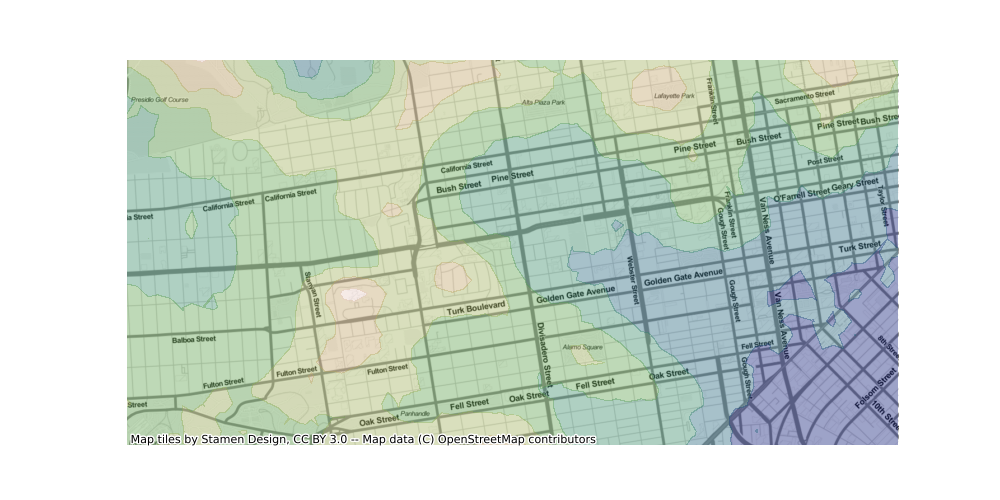

In [15]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.set_aspect('equal')
ax.set_axis_off()

ax.tricontourf(
    [p.x for p in lidar_mercator.geometry],
    [p.y for p in lidar_mercator.geometry],
    lidar_mercator.z,
    alpha=0.4,
    cmap='gist_earth'
)

cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite, zoom=15)

## Slope profile

Using the the table `lidar`, we can use the User Defined Table Function (UDTF) `tf_geo_rasterize_slope` to compute the slope profile of the terrain.

In [16]:
sql_query = f"""
SELECT * FROM TABLE(  
  tf_geo_rasterize_slope(
    raster => CURSOR(
      SELECT {x_var}, {y_var}, {z_var} FROM {table_name}
      WHERE sample_ratio((SELECT {target_num_rows} / cast(count(*) as float) FROM {table_name}))
    ),
    bin_dim_meters => 10.0,
    geographic_coords => true,
    neighborhood_fill_radius => 20,
    fill_only_nulls => false,
    compute_slope_in_degrees => true
  )
)
"""

In [17]:
slope = con.select_ipc(sql_query)

In [18]:
slope = gpd.GeoDataFrame(slope, geometry=gpd.points_from_xy(slope[x_var], slope[y_var]), crs="EPSG:4326")

In [19]:
slope["aspect_rad"] = slope.aspect * np.pi/180

The slope is commonly expressed in percentage, so we convert the degrees to percent.

In [20]:
slope["slope_percentage"] = np.tan(slope.slope * np.pi/180) * 100

In [21]:
slope.describe()

,x,y,z,slope,aspect,aspect_rad,slope_percentage
count,134680.000000,134680.000000,134680.000000,133126.000000,94886.000000,94886.000000,133126.000000
mean,-122.440007,37.782060,62.967946,3.135557,184.588442,3.221676,5.509268
std,0.017076,0.006722,23.587570,3.536890,94.302536,1.645890,6.252221
min,-122.469526,37.770462,10.120522,0.000000,0.015409,0.000269,0.000000
25%,-122.454767,37.776216,48.627970,0.000000,90.000000,1.570796,0.000000
50%,-122.440007,37.782060,66.714055,1.971721,180.000000,3.141593,3.442661
75%,-122.425247,37.787904,81.113836,5.094846,270.000000,4.712389,8.915696
max,-122.410487,37.793658,110.149622,24.898171,360.000000,6.283185,46.414574


## Visualizing the slope

In [22]:
slope_mercator = slope.to_crs(epsg=3857)

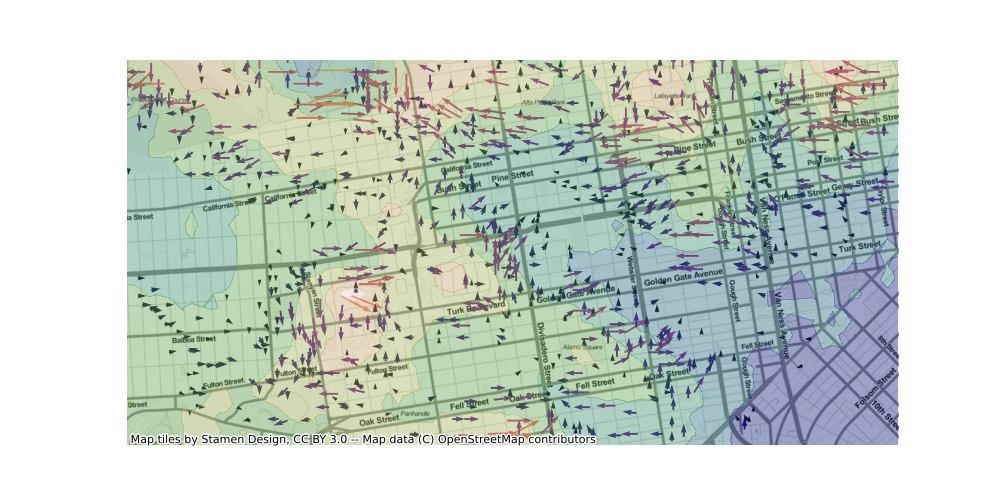

In [23]:
fig, ax = plt.subplots(figsize=(10, 5))


ax.set_aspect('equal')
ax.set_axis_off()

# sample a subset for faster visualization and only slopes above 5deg
sample = slope_mercator[slope_mercator.slope_percentage>5].sample(1_000)

U = np.cos(sample.aspect_rad) * sample.slope_percentage
V = np.sin(sample.aspect_rad) * sample.slope_percentage

ax.quiver(
    [p.x for p in sample.geometry],
    [p.y for p in sample.geometry],
    U, V, sample.slope,
    cmap='magma'
)

# basemaps
ax.tricontourf(
    [p.x for p in lidar_mercator.geometry],
    [p.y for p in lidar_mercator.geometry],
    lidar_mercator.z,
    alpha=0.4,
    cmap='gist_earth'
)

cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite, zoom=15)

## Slope classification

Once we have the slope, we can classify the values in high, medium or low slopes. Here we are only interested in knowing the classification count over the whole area. Note that you could easily use geopandas to create parcels and have this information for every parcel instead.

We use an arbitrary classification:
* low: <5%
* medium: >=5%, <15%
* low: >=15%

In [24]:
slope_counts = {
    "low": slope[slope.slope_percentage<5].count().x,
    "medium": slope[(slope.slope_percentage>=5) & (slope.slope_percentage<15)].count().x,
    "high": slope[slope.slope_percentage>=15].count().x
}

In [25]:
def classification_plot(slope_counts):
    fig, ax = plt.subplots()

    x = [0, 1, 2]
    labels = ["low", "medium", "high"]

    ax.bar(
        x,
        [slope_counts["low"], slope_counts["medium"], slope_counts["high"]]
    )

    ax.set_ylabel('Count')
    ax.set_xticks(x, labels)
    
    plt.show()

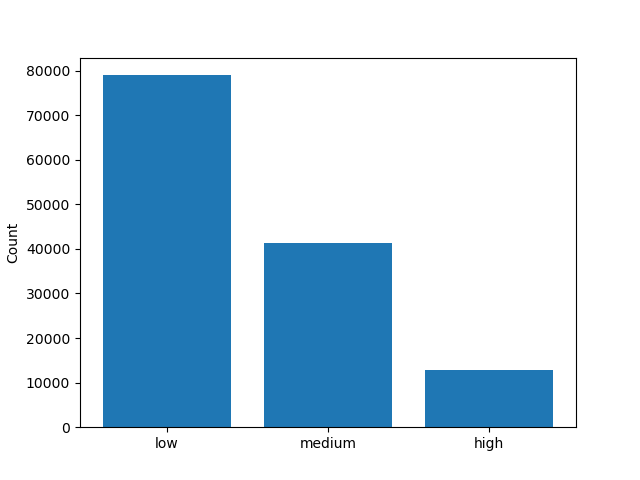

In [26]:
classification_plot(slope_counts)

### With a User Defined Function

Instead of doing this classification in Python, you can define your own function directly in Python and "send" it to the database. This way, HeavyDB handles the parallelism/scaling for you. With large dataset, it can make a great difference. These functions are called User Defined Functions (UDF).

The library [RBC](https://rbc.readthedocs.io/) for Remote Backend Controler can create UDF for HeavyDB. For more information on RBC/HeavyDB support, see [here](https://docs.heavy.ai/udf-and-udtf/remote-backend-compiler-rbc).

RBC needs to connect to the database to register functions.

In [27]:
heavydb = rbc.RemoteHeavyDB(
    user='admin',
    password='HyperInteractive',
    host='localhost',
    port=6274,
    dbname='heavyai',
)

Then you can declare your functions using a Python like syntax. Again, see the documentation for more information about the supported features.

Bellow is are two examples of a UDFs. `classify_slope_int` returns an integer which value depends on the slope. Similarly, `classify_slope` returns directly a string. Note that Python strings are not used. This is because of how RBC works with HeavyDB.

In [28]:
@heavydb("double(double)")
def classify_slope_int(slope):
    slope = np.tan(slope * np.pi/180) * 100
    if slope <= 5:
        res = 0
    elif 5 < slope < 15:
        res = 1
    else:
        res = 2
    return res


@heavydb("TextEncodingNone(double)")
def classify_slope(slope):
    slope = np.tan(slope * np.pi/180) * 100
    if slope <= 5:
        res = rbc.heavydb.TextEncodingNone("low")
    
    if 5 < slope < 15:
        res = rbc.heavydb.TextEncodingNone("medium")

    if slope >= 15:
        res = rbc.heavydb.TextEncodingNone("high")
    
    return res

Once all functions are defined, they need to be registered to HeavyDB.

In [29]:
heavydb.register()

'k8-sse3' is not a recognized processor for this target (ignoring processor)
'k8-sse3' is not a recognized processor for this target (ignoring processor)
'k8-sse3' is not a recognized processor for this target (ignoring processor)
'k8-sse3' is not a recognized processor for this target (ignoring processor)
'k8-sse3' is not a recognized processor for this target (ignoring processor)
'k8-sse3' is not a recognized processor for this target (ignoring processor)
'k8-sse3' is not a recognized processor for this target (ignoring processor)
'k8-sse3' is not a recognized processor for this target (ignoring processor)


From there, we can use `classify_slope` as any other function already available in HeavyDB.

In [30]:
sql_query = f"""
SELECT classify_slope(slope) from (
  SELECT slope FROM TABLE(  
    tf_geo_rasterize_slope(
      raster => CURSOR(
        SELECT {x_var}, {y_var}, {z_var} FROM {table_name}
        WHERE sample_ratio((SELECT {target_num_rows} / cast(count(*) as float) FROM {table_name}))
      ),
      bin_dim_meters => 10.0,
      geographic_coords => true,
      neighborhood_fill_radius => 20,
      fill_only_nulls => false,
      compute_slope_in_degrees => true
    )
  )
)
"""

`select_ipc` cannot yet be used for `TextEncodedNone` output. As seen above, pandas can be used or `heavyai` has support for cursors. Compared to `select_ipc` the performance of the i/o is lower, otherwize the query is executed in the same way on the database.

In [31]:
with con.cursor() as cursor:
    slope = np.array(list(cursor.execute(sql_query)))

In [32]:
slope = slope[slope != np.array(None)]
labels, counts = np.unique(slope, return_counts=True)

slope_counts = {label: count for label, count in zip(labels, counts)}

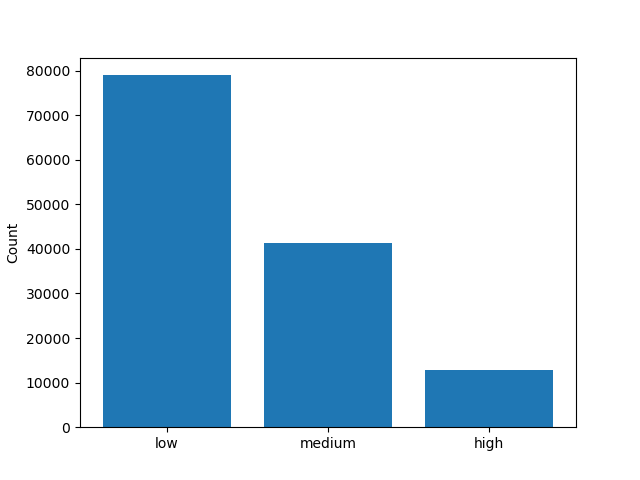

In [33]:
classification_plot(slope_counts)

Using RBC allows you to create new functions which